## Multilabel Classification (WIP)

In [55]:
from sklearn import datasets
from kiwigrad import MLP, Value, Layer, draw_dot
import pandas as pd
import numpy as np
import edamame.eda as eda
import time

### Dataset

In [56]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print(X.shape)
print(type(X))
print(y.shape)
print(type(y))
num_classes = len(np.unique(y))

(150, 4)
<class 'numpy.ndarray'>
(150,)
<class 'numpy.ndarray'>


In [57]:
X = pd.DataFrame(X, columns=iris.feature_names)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [58]:
y = pd.DataFrame(y, columns=['y'])
y.head()

,y
0,0
1,0
2,0
3,0
4,0


In [59]:
X_train, y_train, X_test, y_test = eda.setup(X,y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(112, 4)
(38, 4)
(112, 1)
(38, 1)


In [60]:
X_train_s = eda.scaling(X_train)
X_test_s = eda.scaling(X_test)

In [61]:
y_train_ohe = np.eye(num_classes)[y_train.squeeze().to_numpy()]
y_train_ohe[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [62]:
inputs = [[Value(i) for i in elem] for elem in X_train_s.to_numpy()]
print(inputs[0])

[Value(data=-1.018271, grad=0.000000), Value(data=1.286460, grad=0.000000), Value(data=-1.393389, grad=0.000000), Value(data=-1.362177, grad=0.000000)]


### Multi layer perceptron

In [63]:
class PotNet(MLP):
    def __init__(self):
        layers = [
            Layer(nin=4, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=3, bias=True, activation="linear")
        ]
        super().__init__(layers=layers)

model = PotNet()
y_pred = model(inputs[0])
print(y_pred)

[Value(data=1.518898, grad=0.000000), Value(data=0.014530, grad=0.000000), Value(data=1.348150, grad=0.000000)]


### Full batch gradient descent with squared error loss

In [65]:
epochs = 200
lr = 0.00001
for epoch in range(epochs):
    s = time.monotonic()
    for i in range(len(inputs)):
        forward = model(inputs[i])
        exp_forward = [elem.exp() for _, elem in enumerate(forward)]
        norm_term = Value(0.)
        for _, elem in enumerate(exp_forward):
            norm_term = norm_term + elem
        softmax_vec = [elem / norm_term for _, elem in enumerate(exp_forward)]
        bce_losses = []
        for j in range(len(softmax_vec)):
            output = softmax_vec[j]
            target = Value(y_train_ohe[i][j])
            neg_output = Value(1.) - softmax_vec[j]
            bce_loss = -(target * output.log() + (Value(1)-target)*neg_output.log())
            bce_losses.append(bce_loss)
        BCEloss = Value(0.)
        for _, single_loss in enumerate(bce_losses):
            BCEloss = BCEloss + single_loss
        BCEloss.backward()
        for p in model.parameters():
            p.data += -lr * p.grad
        model.zero_grad()
    e = time.monotonic()
    t = e - s
    if epoch % 10 == 0:
        print(f"epoch: {epoch} | loss: {BCEloss.data:.2f} | time: {t:.2f} sec.")
        
        

epoch: 0 | loss: 4.55 | time: 0.11 sec.
epoch: 10 | loss: 4.36 | time: 0.06 sec.
epoch: 20 | loss: 4.18 | time: 0.05 sec.
epoch: 30 | loss: 4.02 | time: 0.05 sec.
epoch: 40 | loss: 3.87 | time: 0.06 sec.
epoch: 50 | loss: 3.74 | time: 0.06 sec.
epoch: 60 | loss: 3.65 | time: 0.05 sec.
epoch: 70 | loss: 3.59 | time: 0.06 sec.
epoch: 80 | loss: 3.54 | time: 0.06 sec.
epoch: 90 | loss: 3.48 | time: 0.06 sec.
epoch: 100 | loss: 3.43 | time: 0.09 sec.
epoch: 110 | loss: 3.37 | time: 0.05 sec.
epoch: 120 | loss: 3.32 | time: 0.06 sec.
epoch: 130 | loss: 3.26 | time: 0.06 sec.
epoch: 140 | loss: 3.20 | time: 0.06 sec.
epoch: 150 | loss: 3.14 | time: 0.06 sec.
epoch: 160 | loss: 3.08 | time: 0.05 sec.
epoch: 170 | loss: 2.98 | time: 0.06 sec.
epoch: 180 | loss: 2.87 | time: 0.05 sec.
epoch: 190 | loss: 2.76 | time: 0.05 sec.


In [66]:
index = 0
print(y_train_ohe[index])
forward = model(inputs[index])
exp_forward = [elem.exp() for _, elem in enumerate(forward)]
norm_term = Value(0.)
for _, elem in enumerate(exp_forward):
    norm_term = norm_term + elem
softmax_vec = [elem / norm_term for _, elem in enumerate(exp_forward)]
print(softmax_vec)

[1. 0. 0.]
[Value(data=0.933446, grad=0.000000), Value(data=0.037423, grad=0.000000), Value(data=0.029131, grad=0.000000)]


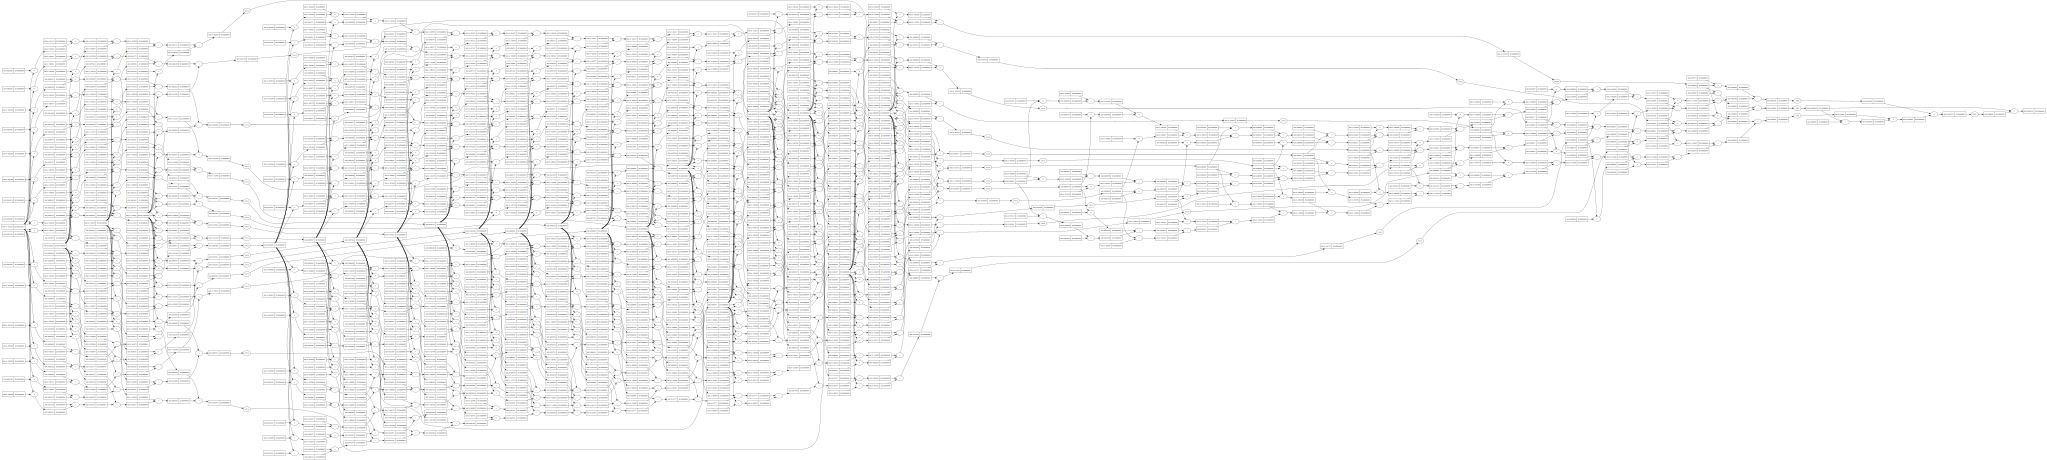

In [67]:
draw_dot(softmax_vec[0])